In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import numpy as np
from tqdm.autonotebook import tqdm
from torch.utils.data import random_split
import torch.optim as optim

In [ ]:
# Import previous files
%run data_preparation.ipynb
%run model.ipynb

In [8]:
# Best params
batch_size = 32
lr = 0.0032714662050235
n_filters1 = 8
n_filters2 = 64

In [9]:
# Data
full_dataset = MNIST(root='./data', train=True, download=False, transform=trasform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_dataset = MNIST(root='./data', train=False, download=True, transform=trasform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [10]:
# Model
model = CNN(n_filters1, n_filters2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

In [12]:
# Training
for epoch in tqdm(range(5)):
        # Обучение
        model.train()
        running_train_loss = 0
        for iter, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        # Валидация
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for iter, (X_batch, y_batch) in enumerate(val_loader):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
# For train data
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for x, y in test_loader:
        outputs = model(x)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())  # for ROC AUC

In [20]:
# Metrics
print(f'Precision: {precision_score(y_true, y_pred, average='macro'):.4f}')
print(f'Recall: {recall_score(y_true, y_pred, average='macro'):.4f}')
print(f"F1-score: {f1_score(y_true, y_pred, average='macro'):.4f}")

y_true_np = np.array(y_true)
y_probs_np = np.array(y_probs)
roc_auc = roc_auc_score(y_true_np, y_probs_np, multi_class='ovr')
print(f"ROC AUC: {roc_auc:.4f}")

print("\nFull report:\n", classification_report(y_true, y_pred, digits=4))

Precision: 0.9872
Recall: 0.9871
F1-score: 0.9871
ROC AUC: 0.9998

Full report:
               precision    recall  f1-score   support

           0     0.9908    0.9929    0.9918       980
           1     0.9965    0.9894    0.9929      1135
           2     0.9744    0.9952    0.9847      1032
           3     0.9872    0.9931    0.9901      1010
           4     0.9898    0.9847    0.9872       982
           5     0.9865    0.9854    0.9860       892
           6     0.9947    0.9812    0.9879       958
           7     0.9834    0.9815    0.9825      1028
           8     0.9917    0.9805    0.9861       974
           9     0.9774    0.9871    0.9822      1009

    accuracy                         0.9872     10000
   macro avg     0.9872    0.9871    0.9871     10000
weighted avg     0.9873    0.9872    0.9872     10000



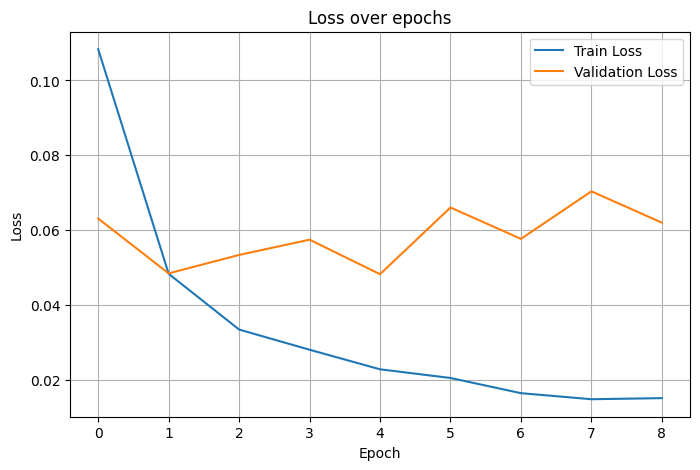

In [21]:
# Loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.grid(True)
plt.show()

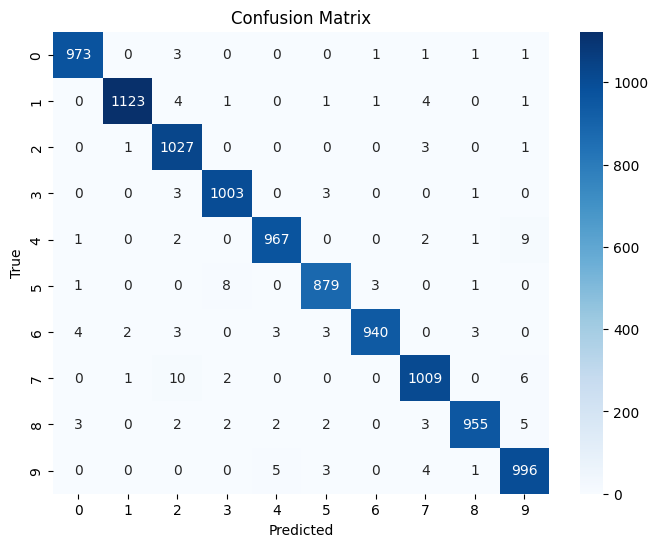

In [22]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

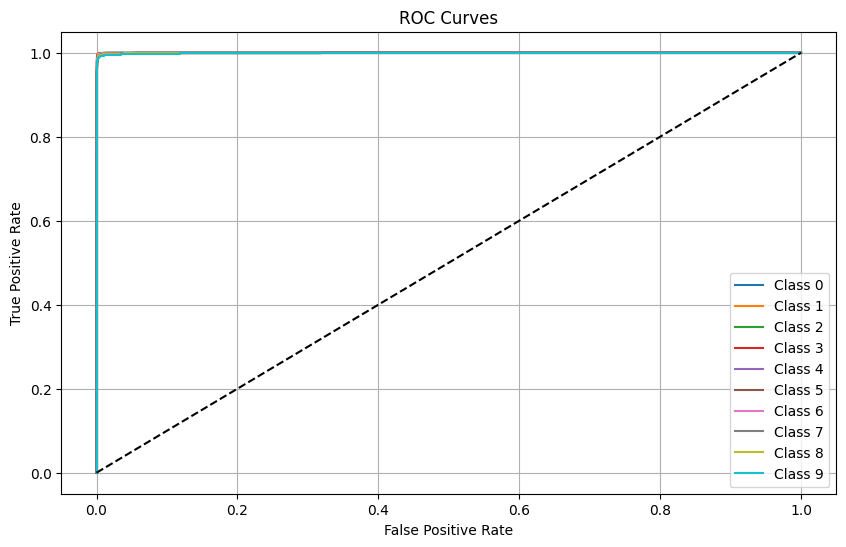

In [24]:
# One-hot true labels
y_true_binarized = label_binarize(y_true_np, classes=range(10))

plt.figure(figsize=(10, 6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_probs_np[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()

In [25]:
torch.save(model, 'best_model.pth')

In [27]:
hyperparams = {'batch_size': batch_size, 'lr': lr, 'n_filters1': n_filters1, 'n_filters2': n_filters2}
import json
with open('best_hyperparams.json', 'w') as f:
    json.dump(hyperparams, f)